# 深層学習で数字認識 AI

## １ 目的

人工知能ライブラリ Keras で MNIST データを学習させ、手書き数字を認識できる人工知能（モデル）を作る。

## ２ 準備

### プログラム・セットアップ

このプログラムは主に Keras.io の [MNIST 手書き数字データベースを利用する数字認識モデルを学習する例](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py) に基づいたものである。

* [Keras](https://keras.io/) Python の深層学習ライブラリ
   * [日本語版のドキュメンテーショんはこちら](https://keras.io/ja/)
* Keras の利用するテンソル計算ライブラリ [TensorFlow](https://www.tensorflow.org/) (ニューラルネットワーク)
* [Python](https://www.python.jp/pages/about.html) プログラミング言語
* [Jupyter](https://jupyter.org/) ブラウザーでのプログラム実行環境
* [NumPy](https://ja.wikipedia.org/wiki/NumPy) プログラミング言語 Python における数値計算ライブラリ
* [Matplotlib](https://ja.wikipedia.org/wiki/Matplotlib) プログラミング言語 Python およびその科学計算用ライブラリ NumPy のためのグラフ描画ライブラリ

In [1]:
%matplotlib notebook

import IPython
import itertools
import keras
import numpy as np
import os
import matplotlib.pyplot as plt

from collections import Counter

from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import plot_model

from matplotlib import rcParams
from matplotlib.image import imread
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 
                               'Yu Gothic', 
                               'Meirio', 
                               'Takao', 
                               'IPAexGothic', 
                               'IPAPGothic', 
                               'VL PGothic', 
                               'Noto Sans CJK JP']

from sklearn.metrics import confusion_matrix

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

Using TensorFlow backend.


### データを準備

1. データを取得して、プログラムに読み込む
   * [MNIST 手書き数字データベース](https://keras.io/ja/datasets/#mnist)
      * 60,000枚の28x28，10個の数字の白黒画像と10,000枚のテスト用画像データセット
1. 使用データを分けておく
   * *training*: モデル構築時に使うデータ
   * *validation*: 検証用データ
   * *test*: 試験用データ

### MNIST 手書数字データとは？

### Load the MNIST data

In [ ]:
(x_train, y_train), (_x_validate, _y_validate) = mnist.load_data()

### Display sample for each digit (class)

In [ ]:
fig, ((ax0, ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8, ax9)) = plt.subplots(2, 5, figsize=(8,4))

for i,ax in enumerate([ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]):
    idx = np.where(y_train[0:20]==i)[0][0]
    ax.imshow(x_train[idx], cmap='gray')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

plt.subplots_adjust(top=0.91)
plt.tight_layout(pad=2.0)
#plt.subplots_tool()
plt.suptitle('図１：MNIST 手書数字データベースの画像')
plt.show()

plt.savefig('図１.png', dpi=300)

### Show distribution of classes

In [ ]:
digit_counts = Counter(y_train)

_, ax = plt.subplots(1, 1, figsize=(8,4))
ax.bar(digit_counts.keys(), digit_counts.values())
ax.set_xticks(range(0,10))
ax.set_xlabel('各数字（クラス）')
ax.set_ylabel('個数')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.suptitle('図２：学習データの各数字の個数（棒グラフ）')
plt.tight_layout(pad=3.0)
plt.show()

plt.savefig('図２.png', dpi=300)

## ３：実験

### Experiments: Multilayer Perceptron  (basic) vs Convolutional Neural Network (modern)

#### Multilayer Perceptron

Using the most basic of neural network architectures, confirm loss and accuracy for 2- and 4-layer Multilayer Perceptrons, training across 12 and 24 epochs.


#### Convolutional Neural Network

In comparison to the simple architecture of Multilayer Perceptrons, confirm loss and accuracy for 8- and 16-layer Convolutional Neural Network (CNN), training across 12 and 24 epochs.

This will also illustrate how deeper networks should do better than shallower ones.

####  Define some constants

We will use these across both experiments.

In [2]:
BATCH_SIZE = 128
NUM_CLASSES = 10

### ３.１： Experiment, Part I: Multilayer Perceptrons

1. 2-layer Perceptron
   * 12 epochs
   * 24 epochs
1. 4-layer Perceptron
   * 12 epochs
   * 24 epochs

### Prepare data for use with Multilayer Perceptron architecture

In [ ]:
# 乱数ジェネレーターをシード
np.random.seed(1234)

num_test_samples_per_class = 20

# validate データをさらに validate / test に分ける
_test_ids = []
for c in [0,1,2,3,4,5,6,7,8,9]:
    _idx = np.random.choice(np.where(_y_validate==c)[0], 
                           size=(num_test_samples_per_class,),
                           replace=False)
    _test_ids.extend(_idx)

# create index masks for validation- and test-sets
_test = np.zeros(_x_validate.shape[0], dtype=bool)
_test[_test_ids] = True
_validate = ~_test

x_validate = _x_validate[_validate, :, :]
y_validate = _y_validate[_validate]

x_test = _x_validate[_test, :, :]
y_test = _y_validate[_test]

# reshape for a flattened input layer 28 x 28 pixels -> 784
x_train = x_train.reshape(x_train.shape[0], 784)
x_validate = x_validate.reshape(x_validate.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

# transfrom from 8-bit int value to float in range [0.0, 1.0]
x_train = x_train.astype('float32')
x_validate = x_validate.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_validate /= 255
x_test /= 255
print('Data for Multilayer Perceptron experiment:')
print('  x_train shape: {}'.format(x_train.shape))
print('  x_validate shape: {}'.format(x_validate.shape))
print('  x_test shape: {}'.format(x_test.shape))
print('  {} training samples'.format(x_train.shape[0]))
print('  {} validation samples'.format(x_validate.shape[0]))
print('  {} test samples'.format(x_test.shape[0]))

In [ ]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_validate = keras.utils.to_categorical(y_validate, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

### Build/compile Multilayer Perceptron models

In [ ]:
models = []

#### モデル１: 2-layer Perceptron, 12 epochs

* Simple, 2-layer Perceptron.
* Input layer is the 28 x 28 pixel grayscale image flattened to a 784-element vector.
* Hidden layers are both 16-neurons each, for no particular reason.

c.f. [3BLUE1BROWN Series S3, E1; But what is a Neural Network? | Deep Learning, chapter 1](https://www.youtube.com/watch?reload=9&v=aircAruvnKk)

In [ ]:
perceptron1 = Sequential()

perceptron1.add(Dense(16, input_shape=(784,), activation='relu'))
perceptron1.add(Dense(16, activation='relu'))
perceptron1.add(Dense(16, activation='relu'))
perceptron1.add(Dense(10, activation='softmax'))

perceptron1.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer=keras.optimizers.Adadelta(),
                    metrics=['accuracy'])

print(perceptron1.summary())

models.append(perceptron1)

perceptron1.save('model1_2L_perceptron_12-epochs.h5')
plot_model(perceptron1, 'model1_2L_perceptron_12-epochs.png', show_shapes=True)

#### モデル２: 2-layer Perceptron (clone of above model), but trained over 24 epochs

In [ ]:
perceptron2 = keras.models.clone_model(perceptron1)

perceptron2.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer=keras.optimizers.Adadelta(),
                    metrics=['accuracy'])

print(perceptron2.summary())

models.append(perceptron2)

perceptron2.save('model2_2L_perceptron_24-epochs.h5')
plot_model(perceptron2, 'model2_2L_perceptron_24-epochs.png', show_shapes=True)

#### モデル３: 4-layer Perceptron, 12 epochs

In [ ]:
perceptron3 = Sequential()

perceptron3.add(Dense(16, input_shape=(784,), activation='relu'))
perceptron3.add(Dense(16, activation='relu'))
perceptron3.add(Dense(16, activation='relu'))
perceptron3.add(Dense(16, activation='relu'))
perceptron3.add(Dense(16, activation='relu'))
perceptron3.add(Dense(10, activation='softmax'))

perceptron3.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer=keras.optimizers.Adadelta(),
                    metrics=['accuracy'])

print(perceptron3.summary())

models.append(perceptron3)

perceptron3.save('model3_4L_perceptron_12-epochs.h5')
plot_model(perceptron3, 'model3_4L_perceptron_12-epochs.png', show_shapes=True)

#### モデル４: 4-layer Perceptron (clone of above model), but trained over 24 epochs

In [ ]:
perceptron4 = keras.models.clone_model(perceptron3)

perceptron4.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer=keras.optimizers.Adadelta(),
                    metrics=['accuracy'])

print(perceptron4.summary())

models.append(perceptron4)

perceptron4.save('model2_4L_perceptron_24-epochs.h5')
plot_model(perceptron4, 'model2_4L_perceptron_24-epochs.png', show_shapes=True)

#### Display the Multilayer Perceptron model architectures

Note that the models 1 & 2 have the same architecture, with 2 hidden layers.

Likewise, models 3 & 4 have the same architecture, with 4 hidden layers.

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, sharey=False)

ax1.imshow(imread('model1_2L_perceptron_12-epochs.png'))
ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.set_title('モデル１・モデル２の構造')

ax2.imshow(imread('model3_4L_perceptron_12-epochs.png'))
ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.set_title('モデル３・モデル４の構造')

plt.suptitle('図３：Multilayer Perceptron （単純ニューラルネットワーク）')
plt.tight_layout(pad=3)
plt.show()

plt.savefig('図３.png', dpi=300)

### Train the Multilayer Perceptron models

After training completes, graph the loss & accuracy for all models for both training and validation datasets.

In [ ]:
print('Training Multilayer Perceptron models...')

# models 1 and 3 will be trained across 12 epochs
# models 2 and 4 will be trained across 24 epochs
epochs = [12, 24, 12, 24]

histories = []
for model, num_epochs in zip(models, epochs):
    history = model.fit(x_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=num_epochs,
                        shuffle=True,
                        verbose=1,
                        validation_data=(x_validate, y_validate))
    histories.append(history)
    score = model.evaluate(x_validate, y_validate, verbose=0)
    print('validation loss: {:.5F}, validation accuracy: {:.5F}'.format(*score))
    print('------------------')

#### Display training loss and accuracy graphs for models

In [ ]:
# tick-formatter sets tick label for
# indices 1 and all others divisble by 3
def _tickformatter(v, tn):
    if int(v+1)==1 or int(v+1)%3==0:
        return int(v+1)

In [ ]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, figsize=(8,6))

ax1.plot(histories[0].history['loss'], label='学習データ')
ax1.plot(histories[0].history['val_loss'], label='検証データ')
ax1.set_title('モデル１')
ax1.set_xlim(0,11)
ax1.set_xticks(range(0,12))
ax1.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.plot(histories[1].history['loss'], label='学習データ')
ax2.plot(histories[1].history['val_loss'], label='検証データ')
ax2.set_title('モデル２')
ax2.set_xlim(0,23)
ax2.set_xticks(range(0,24))
ax2.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend(loc='center right')

ax3.plot(histories[2].history['loss'], label='学習データ')
ax3.plot(histories[2].history['val_loss'], label='検証データ')
ax3.set_title('モデル３')
ax3.set_xlim(0,11)
ax3.set_xticks(range(0,12))
ax3.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax4.plot(histories[3].history['loss'], label='学習データ')
ax4.plot(histories[3].history['val_loss'], label='検証データ')
ax4.set_title('モデル４')
ax4.set_xlim(0,23)
ax4.set_xticks(range(0,24))
ax4.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.suptitle('図４：Multilayer Perceptron 学習時のロス率（正解・不正解かい離）')
plt.figtext(0.5, 0.03, '学習回数', fontsize=10, ha='center')
plt.figtext(0.04, 0.5, 'ロス率', fontsize=10, ha='center', rotation=90)
plt.tight_layout(pad=3)
plt.show()

plt.savefig('図４.png', dpi=300)

In [ ]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, figsize=(8,6))

ax1.plot(histories[0].history['acc'], label='学習データ')
ax1.plot(histories[0].history['val_acc'], label='検証データ')
ax1.set_title('モデル１')
ax1.set_xlim(0,11)
ax1.set_xticks(range(0,12))
ax1.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.plot(histories[1].history['acc'], label='学習データ')
ax2.plot(histories[1].history['val_acc'], label='検証データ')
ax2.set_title('モデル２')
ax2.set_xlim(0,23)
ax2.set_xticks(range(0,24))
ax2.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend(loc='center right')

ax3.plot(histories[2].history['acc'], label='学習データ')
ax3.plot(histories[2].history['val_acc'], label='検証データ')
ax3.set_title('モデル３')
ax3.set_xlim(0,11)
ax3.set_xticks(range(0,12))
ax3.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax4.plot(histories[3].history['acc'], label='学習データ')
ax4.plot(histories[3].history['val_acc'], label='検証データ')
ax4.set_title('モデル４')
ax4.set_xlim(0,23)
ax4.set_xticks(range(0,24))
ax4.xaxis.set_major_formatter(plt.FuncFormatter(_tickformatter))
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.suptitle('図５：Multilayer Perceptron 学習時の正解率（予測）')
plt.figtext(0.5, 0.03, '学習回数', fontsize=10, ha='center')
plt.figtext(0.04, 0.5, '正解率', fontsize=10, ha='center', rotation=90)
plt.tight_layout(pad=3)
plt.show()

plt.savefig('図５.png', dpi=300)

#### Test the models

blah, blah, blah

In [ ]:
classes = range(10)

_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, figsize=(8,8))

for idx, (model,ax) in enumerate(zip(models, (ax1, ax2, ax3, ax4))):
    predicted = np.argmax(model.predict(x_test), axis=1)
    actual = np.argmax(y_test, axis=1)
    confusion_mtx = confusion_matrix(actual, predicted)
    
    test_acc = np.sum(predicted==actual) / len(actual)
    #print('model {} accuracy: {}'.format(idx+1, test_acc))
    
    ax.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title('モデル{}:正解率 {}'.format(idx+1, test_acc))
    #ax1.colorbar()
    ax.set_xticks(classes)
    ax.set_yticks(classes)

    thresh = confusion_mtx.max() / 2.
    for i, j in itertools.product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
        ax.text(j, i, confusion_mtx[i, j],
                 horizontalalignment="center",
                 color="white" if confusion_mtx[i, j] > thresh else "black")

ax1.set_xlabel('予測値')
ax1.set_ylabel('正解')       
plt.suptitle('図６：Multilayer Perceptron 試験データにおける正解率')
#plt.figtext(0.5, 0.03, '学習回数', fontsize=10, ha='center')
#plt.figtext(0.04, 0.5, 'ロス率', fontsize=10, ha='center', rotation=90)
plt.tight_layout(pad=3)
plt.show()

plt.savefig('図６.png', dpi=300)


----

## 4. Experiment using Convolutional Neural Networks (advanced NN)

1. 8-layer Convolutional Neural Network (CNN),
   * 12 epochs
   * 24 epochs
1. 16-layer CNN
   * 12 epochs
   * 24 epochs

### Prepare data for use with CNN architecture

In [3]:
(x_train, y_train), (_x_validate, _y_validate) = mnist.load_data()

In [4]:
# 乱数ジェネレーターをシード
np.random.seed(1234)

num_test_samples_per_class = 20

# validate データをさらに validate / test に分ける
_test_ids = []
for c in [0,1,2,3,4,5,6,7,8,9]:
    _idx = np.random.choice(np.where(_y_validate==c)[0], 
                           size=(num_test_samples_per_class,),
                           replace=False)
    _test_ids.extend(_idx)

# create index masks for validation- and test-sets
_test = np.zeros(_x_validate.shape[0], dtype=bool)
_test[_test_ids] = True
_validate = ~_test

x_validate = _x_validate[_validate, :, :]
y_validate = _y_validate[_validate]

x_test = _x_validate[_test, :, :]
y_test = _y_validate[_test]

In [5]:
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_validate = x_validate.reshape(x_validate.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_validate = x_validate.reshape(x_validate.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [6]:
x_train = x_train.astype('float32')
x_validate = x_validate.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_validate /= 255
x_test /= 255
print('Data for CNN experiment:')
print('  x_train shape: {}'.format(x_train.shape))
print('  x_validate shape: {}'.format(x_validate.shape))
print('  x_test shape: {}'.format(x_test.shape))
print('  {} training samples'.format(x_train.shape[0]))
print('  {} validation samples'.format(x_validate.shape[0]))
print('  {} test samples'.format(x_test.shape[0]))

Data for CNN experiment:
  x_train shape: (60000, 28, 28, 1)
  x_validate shape: (9800, 28, 28, 1)
  x_test shape: (200, 28, 28, 1)
  60000 training samples
  9800 validation samples
  200 test samples


In [7]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_validate = keras.utils.to_categorical(y_validate, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [8]:
models = []
epochs = [12, 24, 12, 24]

DROPOUT_RATE = 0.25

### モデル５: 8-layer CNN, 12 epochs

c.f. https://keras.io/examples/mnist_cnn/

In [9]:
cnn1 = Sequential()

cnn1.add(Conv2D(32, kernel_size=(3, 3),
                activation='relu',
                input_shape=input_shape))
cnn1.add(Conv2D(64, (3, 3), activation='relu'))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.25))
cnn1.add(Flatten())
cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dropout(0.5))
cnn1.add(Dense(NUM_CLASSES, activation='softmax'))

cnn1.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adadelta(),
             metrics=['accuracy'])

print(cnn1.summary())

models.append(cnn1)

cnn1.save('model5_8L_CNN_12-epochs.h5')
plot_model(cnn1, 'model5_8L_CNN_12-epochs.png', show_shapes=True)

W0830 12:37:58.713434 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 12:37:58.731956 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 12:37:58.736167 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0830 12:37:58.780680 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is d

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

### モデル６: 8-layer CNN (clone of above CNN model), but trained over 24 epochs

In [10]:
cnn2 = keras.models.clone_model(cnn1)

cnn2.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adadelta(),
             metrics=['accuracy'])

print(cnn2.summary())

models.append(cnn2)

cnn2.save('model6_8L_CNN_24-epochs.h5')
plot_model(cnn1, 'model6_8L_CNN_24-epochs.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

### モデル７:  16-layer CNN, 12 epochs

c.f. https://www.kaggle.com/adityaecdrid/mnist-with-keras-for-beginners-99457

In [11]:
cnn3 = Sequential()

cnn3.add(Conv2D(32, kernel_size=(3, 3),
                  activation='relu',
                  input_shape=input_shape))
cnn3.add(Conv2D(32, kernel_size=(3, 3),
                  activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))
cnn3.add(Dropout(DROPOUT_RATE))
cnn3.add(Conv2D(64, (3, 3), 
                  activation='relu',
                  padding='same'))
cnn3.add(Conv2D(64, (3, 3), 
                  activation='relu',
                  padding='same'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))
cnn3.add(Dropout(DROPOUT_RATE))
cnn3.add(Conv2D(128, (3, 3), 
                  activation='relu',
                  padding='same'))
cnn3.add(Conv2D(128, (3, 3), 
                  activation='relu',
                  padding='same'))
cnn3.add(Dropout(DROPOUT_RATE))
cnn3.add(Flatten())
cnn3.add(Dense(128, activation='relu'))
cnn3.add(BatchNormalization())
cnn3.add(Dropout(DROPOUT_RATE))
cnn3.add(Dense(NUM_CLASSES, activation='softmax'))

cnn3.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adadelta(),
             metrics=['accuracy'])

print(cnn3.summary())

models.append(cnn3)

cnn3.save('model7_16L_CNN_12-epochs.h5')
plot_model(cnn3, 'model7_16L_CNN_12-epochs.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
__________

### モデル８:  16-layer CNN, 24 (same as above) epochs

In [12]:
cnn4 = keras.models.clone_model(cnn3)

cnn4.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adadelta(),
             metrics=['accuracy'])

print(cnn4.summary())

models.append(cnn4)

cnn4.save('model8_16L_CNN_24-epochs.h5')
plot_model(cnn4, 'model8_16L_CNN_24-epochs.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
__________

#### Display the CNN model architectures

Note that the models 5 & 6 have the same CNN architecture, with 8 hidden layers.

Likewise, models 7 & 8 have the same CNN architecture, with 16 hidden layers.

<IPython.core.display.Javascript object>


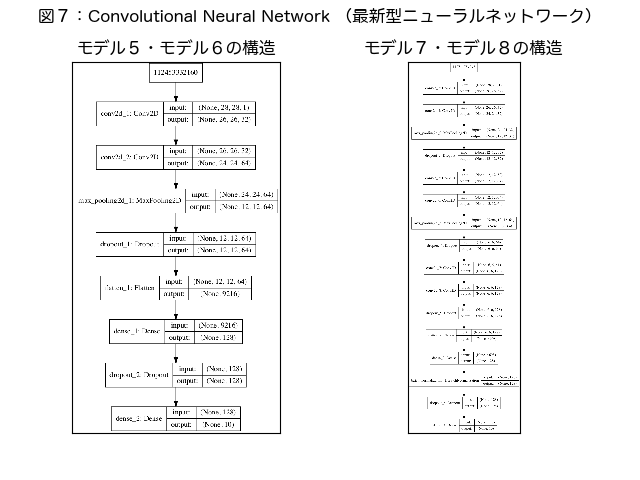

In [13]:
_, (ax1, ax2) = plt.subplots(1, 2, sharey=False)

ax1.imshow(imread('model5_8L_CNN_12-epochs.png'))
ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.set_title('モデル５・モデル６の構造')

ax2.imshow(imread('model7_16L_CNN_12-epochs.png'))
ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.set_title('モデル７・モデル８の構造')

plt.suptitle('図７：Convolutional Neural Network （最新型ニューラルネットワーク）')
plt.tight_layout(pad=3)
plt.show()

plt.savefig('図７.png', dpi=300)

### Train the CNN models

After training completes, graph the loss & accuracy for all models for both training and validation datasets.

In [14]:
print('Training Convolutional Neural Network models...')

histories = []
for model, num_epochs in zip(models, epochs):
    history = model.fit(x_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=num_epochs,
                        shuffle=True,
                        verbose=1,
                        validation_data=(x_validate, y_validate))
    histories.append(history)
    score = model.evaluate(x_validate, y_validate, verbose=0)
    print('validation loss: {:.5F}, validation accuracy: {:.5F}'.format(*score))
    print('------------------')

Training Convolutional Neural Network models...


W0830 12:38:30.121099 140735751172992 deprecation.py:323] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 9800 samples
Epoch 1/12
60000/60000 [==============================] - 105s 2ms/step - loss: 0.2706 - acc: 0.9161 - val_loss: 0.0619 - val_acc: 0.9797
Epoch 2/12
60000/60000 [==============================] - 103s 2ms/step - loss: 0.0924 - acc: 0.9729 - val_loss: 0.0422 - val_acc: 0.9860
Epoch 3/12
60000/60000 [==============================] - 103s 2ms/step - loss: 0.0657 - acc: 0.9801 - val_loss: 0.0367 - val_acc: 0.9882
Epoch 4/12
60000/60000 [==============================] - 103s 2ms/step - loss: 0.0562 - acc: 0.9835 - val_loss: 0.0370 - val_acc: 0.9885
Epoch 5/12
60000/60000 [==============================] - 103s 2ms/step - loss: 0.0469 - acc: 0.9854 - val_loss: 0.0345 - val_acc: 0.9884
Epoch 6/12
60000/60000 [==============================] - 103s 2ms/step - loss: 0.0418 - acc: 0.9875 - val_loss: 0.0301 - val_acc: 0.9904
Epoch 7/12
60000/60000 [==============================] - 90s 2ms/step - loss: 0.0385 - acc: 0.9884 - val_loss: 0.0271 - va

KeyboardInterrupt: 

In [ ]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, figsize=(8,4))

ax1.plot(histories[0].history['loss'], label='学習データ')
ax1.plot(histories[0].history['val_loss'], label='検証データ')
ax1.set_title('モデル１')
ax1.set_xlim(0,11)
ax1.set_xticks([0,11])
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda v,tn: int(v+1)))
ax1.set_ylabel('ロス率')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.plot(histories[1].history['loss'], label='学習データ')
ax2.plot(histories[1].history['val_loss'], label='検証データ')
ax2.set_title('モデル２')
ax2.set_xlim(0,23)
ax2.set_xticks([0,23])
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda v,tn: int(v+1)))
ax2.set_ylabel('ロス率')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax3.plot(histories[2].history['loss'], label='学習データ')
ax3.plot(histories[2].history['val_loss'], label='検証データ')
ax3.plot(histories[0].history['val_loss'], label='検証データ')
ax3.set_title('モデル３')
ax3.set_xlim(0,11)
ax3.set_xticks([0,11])
ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda v,tn: int(v+1)))
ax3.set_ylabel('ロス率')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax4.plot(histories[3].history['loss'], label='学習データ')
ax4.plot(histories[3].history['val_loss'], label='検証データ')
ax4.set_title('モデル４')
ax4.set_xlim(0,23)
ax4.set_xticks([0,23])
ax4.xaxis.set_major_formatter(plt.FuncFormatter(lambda v,tn: int(v+1)))
ax4.set_ylabel('ロス率')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.suptitle('図？：Multilayer Perceptron 学習時の正解・不正解かい離率')
plt.figtext(0.5, 0.05, '学習回数', fontsize=10, ha='center')
plt.tight_layout(pad=3)
plt.show()

## TEST

In [ ]:
model.predict_classes(x_test)

In [ ]:
np.where(y_test==1)[1]

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(8,5))

# graph for training & validation accuracy values
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])

ax1.set_title(r'Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_xlim(0,epochs-1)
ax1.xaxis.set_major_locator(plt.MultipleLocator(1))
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda value,tick_number: int(value+1)))
ax1.legend(['Train', 'Test'], loc='center right', fontsize=8)
ax1.set_facecolor('0.98')
ax1.grid(alpha=0.4, zorder=1)

# graph for training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])

ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_xlim(0,epochs-1)
ax2.xaxis.set_major_locator(plt.MultipleLocator(1))
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda value,tick_number: int(value+1)))
ax2.legend(['Train', 'Test'], loc='center right', fontsize=8)
ax2.set_facecolor('0.98')
ax2.grid(alpha=0.4, zorder=1)

plt.suptitle(r'Accuracy & Loss in Training')
plt.tight_layout(pad=3)
plt.show()

In [ ]:
x_test[0].reshape((28,28)).flatten().shape

In [ ]:
_, ((ax0, ax1, ax2, ax3)) = plt.subplots(1, 4, figsize=(8,3.4))

for i,ax in enumerate([ax0, ax1, ax2, ax3]):
    ax.imshow(x_test[i].reshape((28,28)), cmap='gray')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

plt.subplots_adjust(top=0.91)
plt.tight_layout(pad=2.0)
#plt.subplots_tool()
#plt.suptitle('図：MNIST 手書数字データベースの画像')
plt.show()